In [96]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import warnings

warnings.filterwarnings("ignore")

In [97]:
tf.keras.backend.set_floatx("float64")

class Dist(tf.keras.Model):
    def __init__(self):
        super().__init__()
        
        self.dense1 = tf.keras.layers.Dense(64)
        self.dense2 = tf.keras.layers.Dense(64)
        self.out = tf.keras.layers.Dense(1)
           
    def call(self, x):
        x = tf.nn.tanh(self.dense1(x))
        x = tf.nn.tanh(self.dense2(x))
        
        return tf.math.exp(self.out(x))

    
class DNModel(tf.keras.Model):
    def __init__(self):
        super().__init__()
        
        self.dist1 = Dist()
        self.dist2 = Dist()
        
    def call(self, x):
        psi1 = self.dist1(tf.reshape(x[:,0], (-1,1)))
        psi2 = self.dist2(x)
        
        psi3 = self.dist1(tf.reshape(x[:,1], (-1,1)))
        psi4 = self.dist2(tf.reverse(x, axis=[1]))
        
        return psi1*psi2 + psi3*psi4
    
    def cond(self, x):
        psi1 = self.dist1(tf.reshape(x[:,0], (-1,1)))
        psi2 = self.dist2(x)
        
        psi3 = self.dist1(tf.reshape(x[:,1], (-1,1)))
        psi4 = self.dist2(tf.reverse(x, axis=[1]))
        
        return psi2 + psi3/psi1*psi4
    
    
    
@tf.function
def loss(model, x):
    
    _x = tf.unstack(x, axis=1)
    _x_ = [tf.expand_dims(tmp, axis = 1) for tmp in _x]
    _x2 = tf.transpose(tf.stack(_x_))[0]
    
    psi = model(_x2)
    
    d_psi = [tf.squeeze(tf.gradients(psi, tmp)) for tmp in _x]
    d2_psi = 0
    for ii in range(2):
        d2_psi += tf.stack(tf.gradients(d_psi[ii], _x_[ii]))[0]
        
    lap = 1/psi*(d2_psi)    
    
    E_L = -0.5*lap + 0.5*tf.reshape(tf.reduce_sum(x**2, axis=1), (-1,1))
    E_L += tf.reshape(1/tf.math.sqrt((x[:,0] - x[:,1])**2 + 0.1**2), (-1,1))
    
    E_L = tf.stop_gradient(E_L)
    E = tf.math.reduce_mean(E_L)
    
    
    psi_detach = tf.stop_gradient(psi)
    return E, 2*(tf.math.reduce_mean(psi/psi_detach*E_L) - tf.math.reduce_mean(psi/psi_detach)*E)


@tf.function
def grad(model, x):
    with tf.GradientTape() as tape:
        E, loss_value = loss(model, x)

    return E, tape.gradient(loss_value, model.trainable_variables)



def sample1(model, N, n):
    total = 0
    x_old = tf.random.uniform((N,1), minval=-2, maxval=2, dtype=tf.dtypes.float64)
    psi_old = model.dist1(x_old).numpy()
    
    for i in range(n):
        x_new = x_old + tf.random.uniform((N,1), minval=-1, maxval=1, dtype=tf.dtypes.float64)
        psi_new = model.dist1(x_new).numpy()
      
    
        U = np.random.uniform(0, 1, (N,1))
        mask = ((psi_new/psi_old)**2 > U) #vectorized acceptance criterion
        x_old = x_old.numpy()
        x_new = x_new.numpy()
        
        x_old[mask]   = x_new[mask]  #move walkers
        psi_old[mask] = psi_new[mask]
        x_old = tf.convert_to_tensor(x_old, dtype=tf.dtypes.float64)
        total += np.sum(mask)
    
    return x_old, total

def sample2(model, N, n, x1):
    total = 0
    x_old = tf.random.uniform((N,1), minval=-2, maxval=2, dtype=tf.dtypes.float64)
    x = tf.concat((x1, x_old), axis=1)
    psi_old = model.cond(x).numpy()
    
    for i in range(n):
        x_new = x_old + tf.random.uniform((N,1), minval=-1, maxval=1, dtype=tf.dtypes.float64)
        x = tf.concat((x1, x_new), axis=1)
        psi_new = model.cond(x).numpy()
      
    
        U = np.random.uniform(0, 1, (N,1))
        mask = ((psi_new/psi_old)**2 > U) #vectorized acceptance criterion
        x_old = x_old.numpy()
        x_new = x_new.numpy()
        
        x_old[mask]   = x_new[mask]  #move walkers
        psi_old[mask] = psi_new[mask]
        x_old = tf.convert_to_tensor(x_old, dtype=tf.dtypes.float64)
        total += np.sum(mask)
    
    return x_old, total

In [109]:
N = 1000
num_epochs = 5000
energy = []

tf.random.set_seed(42)
np.random.seed(42)
model = DNModel()
optimizer = tf.keras.optimizers.Adam(epsilon=1e-08)

In [110]:
for epoch in tqdm(range(num_epochs)):
    x1 = sample1(model, N, 20)[0]
    x2 = sample2(model, N, 20, x1)[0]
    x = tf.concat((x1, x2), axis=1)

    E, gradients = grad(model, x)
    energy.append(E)
    
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    if epoch%100 == 0: 
        print(f"epoch: {epoch}, Energy: {E}")

epoch: 0, Energy: 9.083688600304495
epoch: 100, Energy: 5.531420203380758
epoch: 200, Energy: 3.321707231661835
epoch: 300, Energy: 3.2106026099546874
epoch: 400, Energy: 2.6009169069229525
epoch: 500, Energy: 2.5693124365032918
epoch: 600, Energy: 2.588422812653753
epoch: 700, Energy: 2.5746298241977157
epoch: 800, Energy: 2.5642708486913954
epoch: 900, Energy: 2.5626297579240926
epoch: 1000, Energy: 2.5723575469473494
epoch: 1100, Energy: 2.566049677344204
epoch: 1200, Energy: 2.5546503041031086
epoch: 1300, Energy: 2.5594444226193596
epoch: 1400, Energy: 2.591635543357014
epoch: 1500, Energy: 2.5860792948408715
epoch: 1600, Energy: 2.553602035695395
epoch: 1700, Energy: 2.535808497549474
epoch: 1800, Energy: 2.567915240905347
epoch: 1900, Energy: 2.577345243542335
epoch: 2000, Energy: 2.5831803761509664
epoch: 2100, Energy: 2.5676537194497944
epoch: 2200, Energy: 2.5696597847510607
epoch: 2300, Energy: 2.542542525279377
epoch: 2400, Energy: 2.5559285191607937
epoch: 2500, Energy: 2.

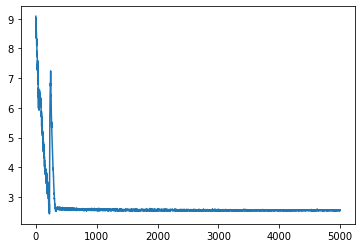

In [111]:
plt.plot(energy)
plt.show()

In [112]:
def f(x):
    x_lin = np.linspace(-4, 4, 1000)
    dx = x_lin[1] - x_lin[0]
    tf_x_lin = tf.convert_to_tensor(x_lin.reshape(-1,1), dtype=tf.dtypes.float64)

    x1 = tf.convert_to_tensor(x*np.ones((1000,1)), dtype=tf.dtypes.float64)

    x_con = tf.concat((x1, tf_x_lin), axis=1)

    psi1 = model.dist1(tf_x_lin).numpy()[:, 0]
    psi2 = model.cond(x_con).numpy()[:, 0]
    
    psi_anal = np.exp(-0.5*x_lin**2)


    plt.plot(x_lin, 1/dx*psi1**2/np.sum(psi1**2))
    plt.plot(x_lin, 1/dx*psi2**2/np.sum(psi2**2))
    plt.plot(x_lin, 1/dx*psi_anal**2/np.sum(psi_anal**2), "--")
    
    plt.plot(x, 0.01, "bo")
    plt.ylim(0, 0.8)
    plt.show()

interact(f, x=(-4.0, 4., 0.1))

interactive(children=(FloatSlider(value=0.0, description='x', max=4.0, min=-4.0), Output()), _dom_classes=('wi…

<function __main__.f(x)>

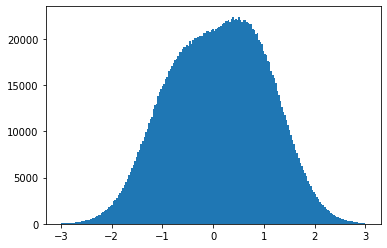

In [113]:
N = 1000000

x1 = sample1(model, N, 20)[0]
x2 = sample2(model, N, 20, x1)[0]
x = tf.concat((x1, x2), axis=1)

x = tf.concat(x, axis=1)
x = tf.reshape(x, (-1,1)).numpy()


bins = np.linspace(-3, 3, 200)
plt.hist(x, bins=bins)
plt.show()